In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas
import pickle
from tqdm import tqdm

In [2]:
%matplotlib inline

# 1. Preparing and plotting the data

In [3]:
hackaton_dir = os.path.expanduser('~/qmenta_1000_brains_challenge')

In [4]:
volumetric_data_dir = os.path.join(hackaton_dir, 'train')

Get the age of each subject from train.csv

In [5]:
age_csv_df = pandas.read_csv(os.path.join(hackaton_dir, 'train.csv'), index_col=0)

In [6]:
age_csv_df.iloc[0].values

array([38.])

In [7]:
age_csv_df

,Age
28634,38.0
28698,47.0
28703,64.0
28708,58.0
28713,12.0
28717,62.0
28723,25.0
28733,28.0
28736,21.0
28740,14.0


Get the volumetric data previously downloaded to your disk 

In [8]:
volumetric_csv_files = sorted(glob.glob(os.path.join(volumetric_data_dir, '*_volumetric.csv')))
len(volumetric_csv_files)

856

We will use the Gray Matter volume normalized by the Intracranial Volume (ICV) as a predictor of age

In [9]:
x_list = list()
y_list = list()
for csv_file in tqdm(volumetric_csv_files):
    subject_id = int(os.path.basename(csv_file).split('_volumetric.csv')[0])
    age_value = age_csv_df.loc[subject_id].values[0]
    volumetric_df = pandas.read_csv(csv_file)
    gm_volume_value = volumetric_df.loc[volumetric_df['label'] == 'Gray matter', 'volume'].values[0]
    icv_value = volumetric_df.loc[volumetric_df['label'] == 'ICV', 'volume'].values[0]
    x_list.append(gm_volume_value / icv_value)
    y_list.append(age_value)

100%|██████████| 856/856 [00:03<00:00, 279.39it/s]


In [10]:
x = np.array(x_list, dtype=np.float32)
y = np.array(y_list, dtype=np.float32)

Let's plot the data and see how the ICV and the age are related in a qualitative manner

Text(0,0.5,'Age (years)')

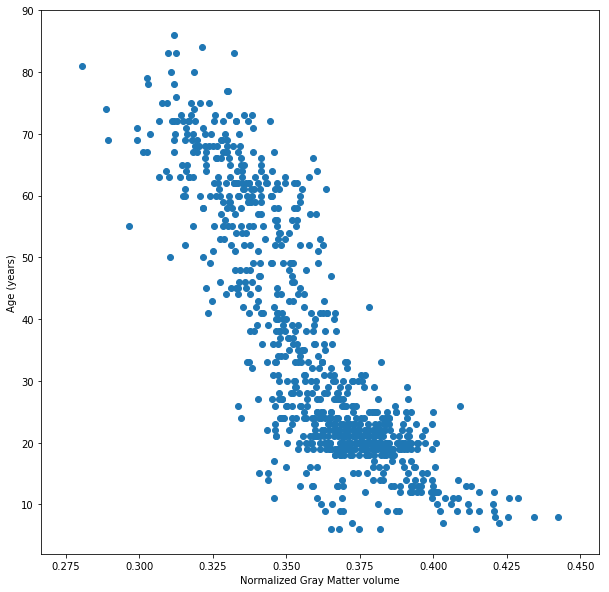

In [11]:
plt.figure(figsize=(10, 10))
plt.scatter(x, y)
plt.xlabel('Normalized Gray Matter volume')
plt.ylabel('Age (years)')

# 2. Linear regression model

It can be seen from the previous plot that the amount of gray matter in the brain correlates linearly with the age. Therefore, we can use a simple linear regression model to predict the age with decent performance in terms of squared error.

We will use scikit-learn to create a Linear Regression model

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
linear_regression_model = LinearRegression(fit_intercept=True, normalize=True)

Make sure the dimensions of X and y are the appropriate ones

In [14]:
x = x[:, np.newaxis]

In [15]:
x.shape

(856, 1)

In [16]:
y.shape

(856,)

Fit the model

In [17]:
linear_regression_model.fit(x, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

Get R² fitting score

In [18]:
linear_regression_model.score(x, y)

0.7103425074235485

Get predictions and coefficients

In [19]:
y_pred = linear_regression_model.predict(x)

In [20]:
intercept, coef = linear_regression_model.intercept_, linear_regression_model.coef_[0]
print(intercept, coef)

(274.3376, -665.9874)


Plot data and regression line

In [21]:
x_reg_line = np.linspace(x.min() - 0.01, x.max() + 0.01, 1000)
reg_line = linear_regression_model.predict(x_reg_line[:, np.newaxis])

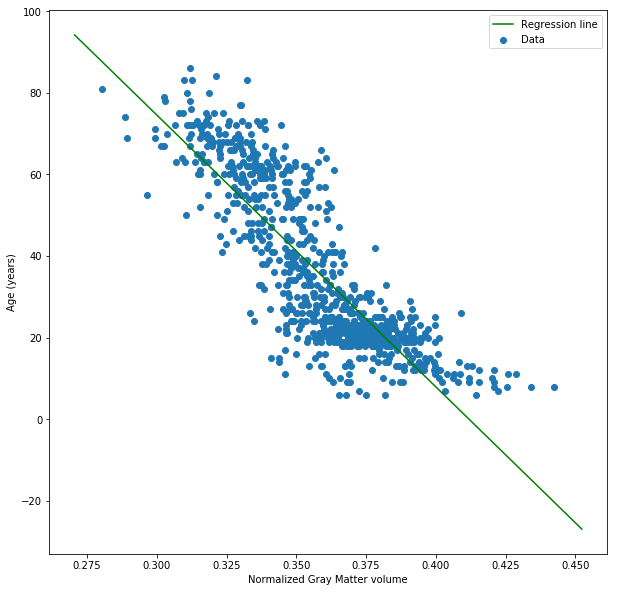

In [22]:
plt.figure(figsize=(10, 10))
plt.scatter(x[:, 0], y, label='Data')
plt.plot(x_reg_line, reg_line, color='green', label='Regression line')
plt.xlabel('Normalized Gray Matter volume')
plt.ylabel('Age (years)')
plt.legend()

Let's plot the residuals also

In [23]:
residuals = y - y_pred

Text(0,0.5,'Residuals (y - y_pred)')

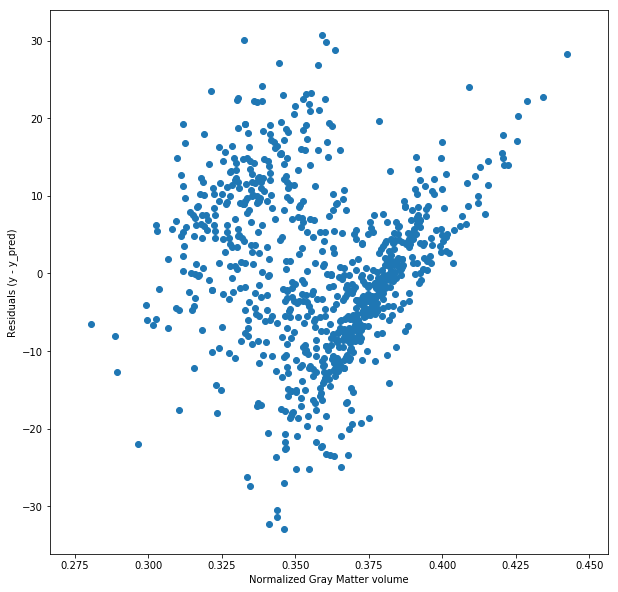

In [24]:
plt.figure(figsize=(10, 10))
plt.scatter(x, residuals)
plt.xlabel('Normalized Gray Matter volume')
plt.ylabel('Residuals (y - y_pred)')

# 3. Persisting the model to disk

We are just going to use **pickle** from Python's standard library to serialize the sklearn instance and dump it to disk.

First we create a folder for our persisted models

In [25]:
persisted_models_dir = os.path.join(hackaton_dir, 'models')

In [26]:
if not os.path.isdir(persisted_models_dir):
    os.makedirs(persisted_models_dir)

Now we simply invoke `pickle.dump()` to persist the model

In [27]:
model_path = os.path.join(persisted_models_dir, 'linear_regression_example.pkl')

In [28]:
with open(model_path, 'wb') as fd:
    pickle.dump(linear_regression_model, file=fd)

Now we can try to load the model from disk and assert that it behaves exactly the same as the in-memory version

In [29]:
with open(model_path, 'rb') as fd:
    loaded_linear_regression_model = pickle.load(fd)

In [30]:
y_pred_original = linear_regression_model.predict(x)
y_pred_loaded = loaded_linear_regression_model.predict(x)

In [31]:
assert np.allclose(y_pred_original, y_pred_loaded)